In [1]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from chaney_utils import (
    gen_social_network, 
    mu_sigma_to_alpha_beta, 
    exclude_new_items, 
    perfect_scores,
    interleave_new_items,
    process_measurement,
    MeanDistanceSimUsers,
    MeanInteractionDistance,
    SimilarUserInteractionSimilarity,
    InteractionTracker,
    RandomRecommender,
    ChaneyContent,
    IdealRecommender,
    load_sim_results,
    merge_results,
    graph_relative_to_ideal
)
from replication_sim import (
    sample_users_and_items,
    run_ideal_sim,
    run_content_sim,
    run_mf_sim,
    run_sf_sim,
    run_pop_sim,
    run_random_sim
)
import warnings
warnings.simplefilter("ignore")

N.B. This notebook is tested for the `main` branch of `t-recs` as of 6/25/2021.

# Generate synthetic data

First, we generate all the user / item data that will be used in each of our simulations (including the social network, which is used in the social filtering model). All parameters are from the Chaney et al. paper (see https://arxiv.org/pdf/1710.11214.pdf).

In [2]:
# Define global constants that apply to all simulations

# random seed
SEED = 1234
GENERATOR = np.random.default_rng(SEED)
# parameters from section 5 of paper
NUM_USERS = 100 
NUM_ITEMS = 10000
NUM_ATTRS = 20
NUM_SIMS = 5 # TODO: CHANGE BACK TO 50
MU_N = 0.98 # parameters provided in paper 
SIGMA = 1e-5
DEBUG = True # consider removing, just determines whether we `savefig` or not

In [3]:
users, items, true_utils, known_utils, social_networks = sample_users_and_items(GENERATOR, NUM_USERS, NUM_ITEMS, NUM_ATTRS, NUM_SIMS, MU_N, SIGMA)

In [4]:
# print shape
print(f"Dimensions of users matrix: {users[0].shape}") # we should see 100 users with 20 attributes
print(f"Dimensions of items matrix: {items[0].shape}") # we should see 1000 items with 20 attributes
print(f"Dimensions of (true) utilities matrix: {true_utils[0].shape}")
print(f"Dimensions of (known) utilities matrix: {known_utils[0].shape}")

Dimensions of users matrix: (100, 20)
Dimensions of items matrix: (10000, 20)
Dimensions of (true) utilities matrix: (100, 10000)
Dimensions of (known) utilities matrix: (100, 10000)


Next, we visualize the true user utilities for each item  to verify that the resulting graph is similar to what appears in the Chaney paper.

Text(0.5, 1.0, 'True user-item utilities (first 250 items)')

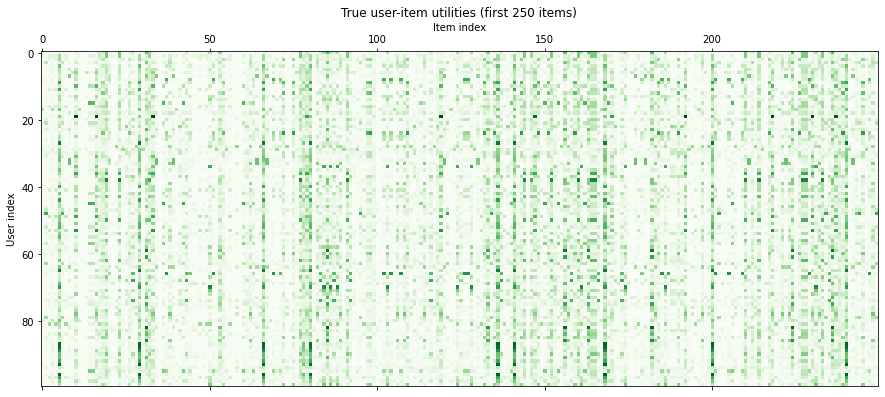

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(true_utils[0][:, :250], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("True user-item utilities (first 250 items)")
# this seems reasonably sparse and matches the picture in the Chaney paper! let's proceed

Text(0.5, 1.0, 'User-item utilities (known to user, first 250 items)')

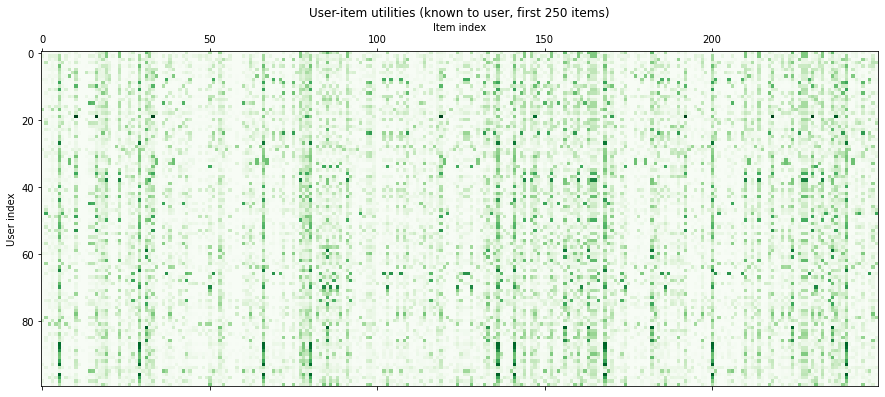

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(known_utils[0][:, :250], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("User-item utilities (known to user, first 250 items)")

Text(0.5, 1.0, 'Item attributes of first 250 items')

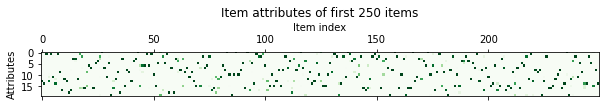

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow((items[0].T)[:, :250], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Attributes')
ax.set_title("Item attributes of first 250 items")

# Custom models/classes/metrics

Next, we create some custom models and metrics that will be used in our replication experiments. Most of the functionality is already in T-RECS, but we "customize" things here so we can measure the same things that Chaney measures. These include:
* Jaccard Similarity for pairs of similar users, where "similar" is defined by cosine similarity of model's internal user representation
* Ideal recommender system
* Random recommender system (randomly recommends items)
* Chaney content filtering system (updates internal representation of users by using `scipy.optimize.nnls` to solve for the least-squares approximation of user attributes)

In [8]:
# necessary imports
from trecs.models import ContentFiltering, PopularityRecommender, ImplicitMF, SocialFiltering
from trecs.components import Users, Items
from trecs.metrics import InteractionSimilarity

# Repeated Training

Now, we actually run the recommender system models on the synthetic datasets. After each model finishes running, we extract two measures of homogenization (change in Jaccard index averaged over pairs of users that are randomly chosen, and the change in Jaccard index averaged over pairs of users that are most similar to each other by cosine similarity).

Note that this is the "repeated training" case, where algorithms are repeatedly updated with new data at each iteration. 

In [9]:
sim_args = {
    "startup_iters": 10,
    "sim_iters": 90,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_items": NUM_ITEMS,
    "num_attrs": NUM_ATTRS,
    "repeated_training": True
}

model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list), "mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}
rep_train_models = {}

In [10]:
for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utils[i]
    noisy_scores = known_utils[i]
    item_representation = items[i].T
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
        
    rep_train_models["ideal"] = run_ideal_sim(true_prefs, item_representation, true_scores, noisy_scores, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(rep_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    rep_train_models["content_chaney"] = run_content_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    rep_train_models["mf"] = run_mf_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    rep_train_models["sf"] = run_sf_sim(social_network, item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    rep_train_models["popularity"] = run_pop_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    rep_train_models["random"] = run_random_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = rep_train_models[model_key]
        rep_train_results["random_users"][model_key].append(process_measurement(model, "interaction_similarity"))
        rep_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            rep_train_results["sim_users"][model_key].append(process_measurement(model, "similar_user_jaccard"))
            rep_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 10/10 [00:00<00:00, 10.56it/s]
Numba is using threading layer omp - consider TBB
BLAS using multiple threads - can cause oversubscription
found 2 potential runtime problems - see https://boi.st/lkpy-perf
100%|██████████| 90/90 [00:19<00:00,  4.60it/s]


In [15]:
# graphing
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})

# smoothing factor for visualizing curves
sigma = 1

In [16]:
# readable legend keys
id_to_readable = {
    "ideal": "ideal", 
    "content_chaney": "content filtering",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

## Change in Jaccard (users paired randomly)

In [17]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(rep_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(rep_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

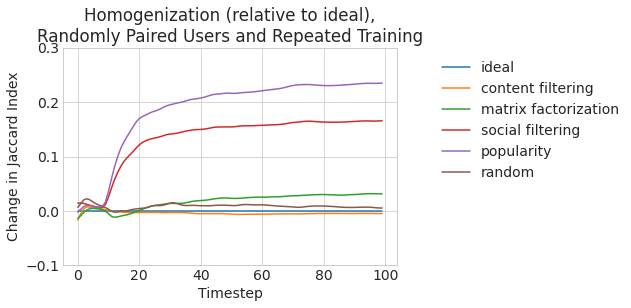

In [18]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.3)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/repeated_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [19]:
# get change in jaccard index just for ideal recommender
relative_jaccard = {}
relative_jaccard["ideal"] = np.zeros(sim_args["startup_iters"] + sim_args["sim_iters"])

for model_key in model_keys:
    if model_key is not "ideal":
        relative_jaccard[model_key] = (np.array(rep_train_results["sim_users"][model_key])).mean(axis=0) # average across 10 trials

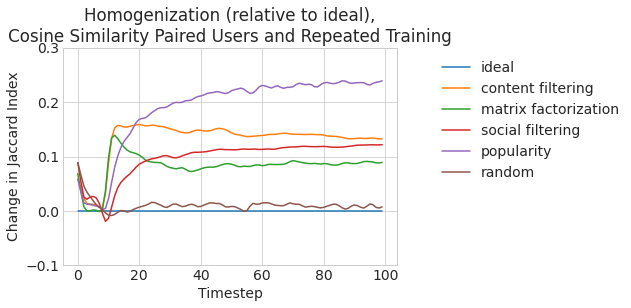

In [20]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.3)
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/repeated_training_sim_pair.pdf', bbox_inches = "tight")

## Average distance between mean items

In [21]:
# get change in jaccard index just for ideal recommender
ideal_dist = np.array(rep_train_results["mean_item_dist"]["ideal"])
relative_dist = {}

for model_key in model_keys:
    abs_dist = np.array(rep_train_results["mean_item_dist"][model_key])
    relative_dist[model_key] = (abs_dist - ideal_dist).mean(axis=0) # average across 10 trials

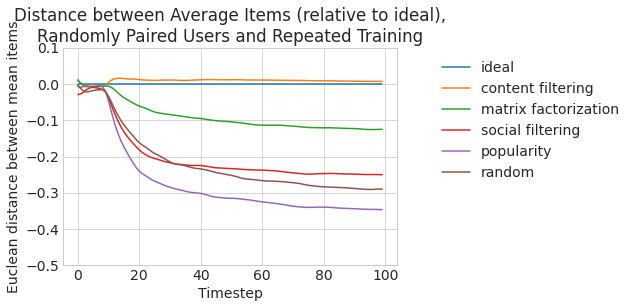

In [22]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Euclean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/repeated_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

## Change in Mean Item Distance (similar users paired)

In [23]:
# get change in jaccard index just for ideal recommender
relative_dist = {}
relative_dist["ideal"] = np.zeros(sim_args["startup_iters"] + sim_args["sim_iters"])

for model_key in model_keys:
    if model_key is not "ideal":
        relative_dist[model_key] = (np.array(rep_train_results["sim_user_dist"][model_key])).mean(axis=0) # average across 10 trials

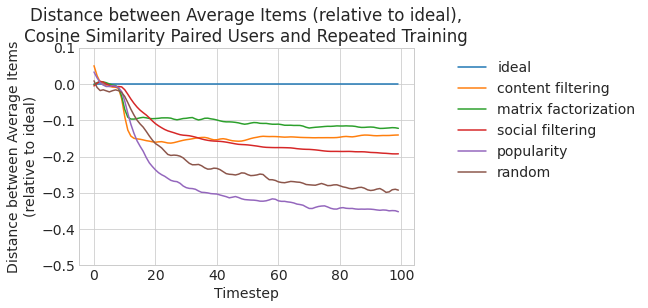

In [24]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Repeated Training")
if not DEBUG:
    plt.savefig('./figures/repeated_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

# Single training

We do the same training with all of the same models just as we did earlier, but now we only train each model once - following the startup phase.

In [25]:
# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list), "mean_item_dist": defaultdict(list), "sim_user_dist": defaultdict(list)}

sim_args = {
    "startup_iters": 50,
    "sim_iters": 50,
    "new_items_per_iter": 10,
    "attention_exp": -0.8, # from Chaney paper, attention function is f(n) = n^(-0.8)
    "num_users": NUM_USERS, 
    "num_items": NUM_ITEMS,
    "num_attrs": NUM_ATTRS,
    "repeated_training": False
}

for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utils[i]
    noisy_scores = known_utils[i]
    item_representation = items[i].T
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [GENERATOR.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
    
    single_train_results["ideal"] = run_ideal_sim(true_prefs, item_representation, true_scores, noisy_scores, pairs, sim_args, GENERATOR)
    ideal_interactions = np.hstack(process_measurement(single_train_results["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    single_train_results["content_chaney"] = run_content_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    single_train_results["mf"] = run_mf_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    single_train_results["sf"] = run_sf_sim(social_network, item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    single_train_results["popularity"] = run_pop_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    single_train_results["random"] = run_random_sim(item_representation, noisy_scores, pairs, ideal_interactions, sim_args, GENERATOR)
    
    # extract results from each model
    for model_key in model_keys:
        model = single_train_results[model_key]
        single_train_results["random_users"][model_key].append(process_measurement(model, "interaction_similarity"))
        single_train_results["mean_item_dist"][model_key].append(process_measurement(model, "mean_interaction_dist"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            single_train_results["sim_users"][model_key].append(process_measurement(model, "similar_user_jaccard"))
            single_train_results["sim_user_dist"][model_key].append(process_measurement(model, "sim_user_dist"))

100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


## Change in Jaccard (users paired randomly)

In [33]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(single_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(single_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

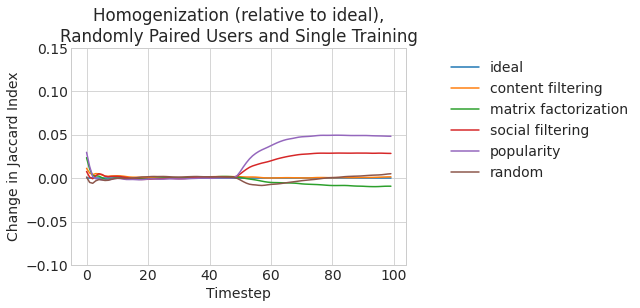

In [34]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.15)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/single_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [35]:
# get change in jaccard index just for ideal recommender
relative_jaccard = {}
relative_jaccard["ideal"] = np.zeros(sim_args["startup_iters"] + sim_args["sim_iters"])

for model_key in model_keys:
    if model_key is not "ideal":
        relative_jaccard[model_key] = (np.array(single_train_results["sim_users"][model_key])).mean(axis=0) # average across 10 trials

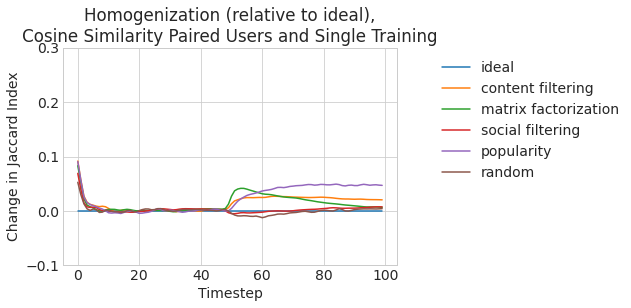

In [36]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Single Training")
plt.ylim(-0.1, 0.3)
if not DEBUG:
    plt.savefig('./figures/single_training_sim_pair.pdf', bbox_inches = "tight")

## Average distance between mean items

In [37]:
# get change in jaccard index just for ideal recommender
ideal_dist = np.array(single_train_results["mean_item_dist"]["ideal"])
relative_dist = {}

for model_key in model_keys:
    abs_dist = np.array(single_train_results["mean_item_dist"][model_key])
    relative_dist[model_key] = (abs_dist - ideal_dist).mean(axis=0) # average across 10 trials

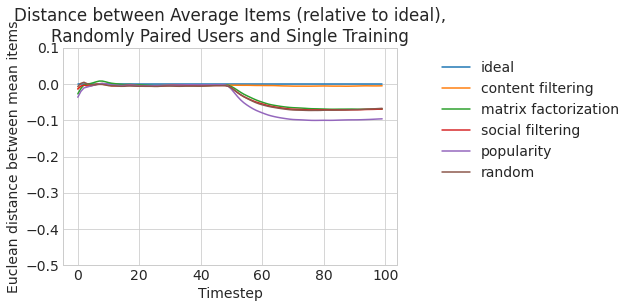

In [38]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Euclean distance between mean items")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nRandomly Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/single_training_mean_dist_rand_pair.pdf', bbox_inches = "tight")

## Change in Mean Item Distance (similar users paired)

In [39]:
# get change in jaccard index just for ideal recommender
relative_dist = {}
relative_dist["ideal"] = np.zeros(sim_args["startup_iters"] + sim_args["sim_iters"])

for model_key in model_keys:
    if model_key is not "ideal":
        relative_dist[model_key] = (np.array(single_train_results["sim_user_dist"][model_key])).mean(axis=0) # average across 10 trials

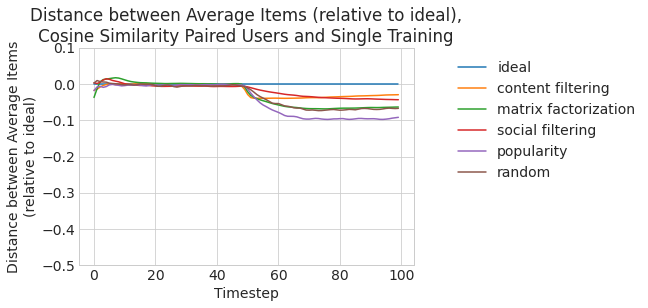

In [40]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_dist[m]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Distance between Average Items\n(relative to ideal)")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.5, 0.1)
plt.title("Distance between Average Items (relative to ideal),\nCosine Similarity Paired Users and Single Training")
if not DEBUG:
    plt.savefig('./figures/single_training_mean_dist_sim_pair.pdf', bbox_inches = "tight")

# Experimental simulations run on cluster

## Repeated training, change in jaccard index (similar users paired)

In [41]:
results = merge_results(["exps/chaney_rep_1", "exps/chaney_rep_2", "exps/chaney_rep_3", "exps/chaney_rep_4"])

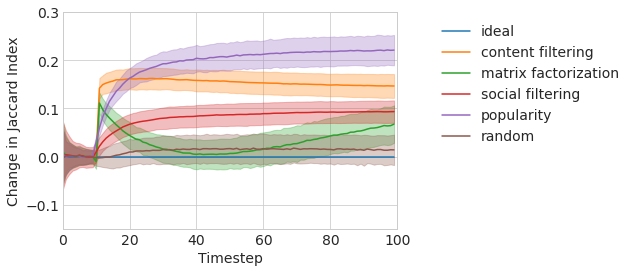

In [42]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
graph_relative_to_ideal(results, "sim_users", model_keys, id_to_readable, absolute_measure=False, mult_sd=1.0)
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.15, 0.3)
plt.xlim(0, 100)
if not DEBUG:
    plt.savefig("figures/repeated_training_sim_pair.pdf", bbox_inches = "tight")

## Single training, change in jaccard index (similar users paired)

In [43]:
results = merge_results(["exps/chaney_single_1", "exps/chaney_single_2", "exps/chaney_single_3", "exps/chaney_single_4"])

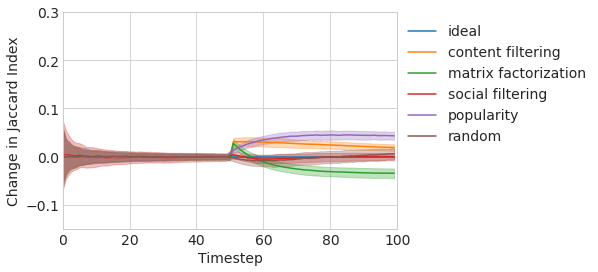

In [44]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
graph_relative_to_ideal(results, "sim_users", model_keys, id_to_readable, absolute_measure=False, mult_sd=1.0)
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.ylim(-0.15, 0.3)
plt.xlim(0, 100)
if not DEBUG:
    plt.savefig("figures/single_training_sim_pair.pdf", bbox_inches = "tight")